Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Manuela Bastidas Olivares y Nicolás Guarín-Zapata 2024.

# Solucion de la ecuación de Poisson usando PINNs

## Descripción del problema

Queremos resolver la siguiente ecuación

\begin{align}
\nabla^2 u(x, y)  = f(x, y)\quad \forall (x, y) \in \Omega\\
u(x, y) = 0\quad \forall (x, y) \in \partial \Omega
\end{align}

En el ejemplo tendremos $\Omega = (0, 1)^2$.


## Aproximación de la función

En este caso tenemos una aproximación

$$u_\theta(x, y) \approx \operatorname{NN}(x, y; \theta)\, ,$$

done $\operatorname{NN}$ es una red neuronal con parámetros
entrenables $\theta$.

El residual para este problema estaría dado por

$$R(x) = \nabla^2 u_\theta(x, y)  - f(x, y) \, .$$

Por el caracter no linealidad respecto a los parámetros
$\theta$ de las redes neuronales evaluar el residual
en una serie de puntos $x_i$  y forzarlo a ser cero
en estos puntos, llevaría a un sistema
no lineal de ecuaciones

$$R(x_i, y_i) = 0 \quad \forall x_i\, .$$

## Función de pérdida

Una alternativa a resolver el sistema de ecuaciones anteriormente
planteado es minimizar

$$\min_\theta \frac{1}{N}\sum_{i}^N |R(x_i, y_i)|^2 \, .$$

Que sería exactamente 0 si cada uno de los residuales es igual a 0.

A este problema le harían falta las condiciones de frontera. Para
esto se propone una función objetivo que las incluya

$$\min_\theta \lambda_2\frac{1}{N}\sum_{i}^N R(x_i, y_i)^2 
+ \lambda_2 \frac{1}{M}\sum_{\substack{i\\ (x_i, y_i) \in \partial\Omega}}^M u_\theta(x_i, y_i)^2\, .$$

## Ejemplo computacional

In [1]:
# Esto permite tener gráficos interactivos en
# el caso de correrse en Google Colab
if 'google.colab' in str(get_ipython()):
    %pip install ipympl
    from google.colab import output
    output.enable_custom_widget_manager()

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.stats import qmc
from torch.autograd import grad
import time

In [4]:
if 'google.colab' in str(get_ipython()):
    style = "https://raw.githubusercontent.com/nicoguaro/pinns_mapi-3/main/notebooks/clean.mplstyle"
else:
    style = "./clean.mplstyle"
plt.style.use(style)

## Puntos de muestreo

Para entrenar la PINN, generaremos el dominio utilizando la estrategia de muestreo `LatinHypercube` (LHS). LHS asegura que las muestras cubran uniformemente el espacio de entrada, garantizando que las muestras no estén agrupadas en un área pequeña, sino que estén distribuidas en todo el espacio.

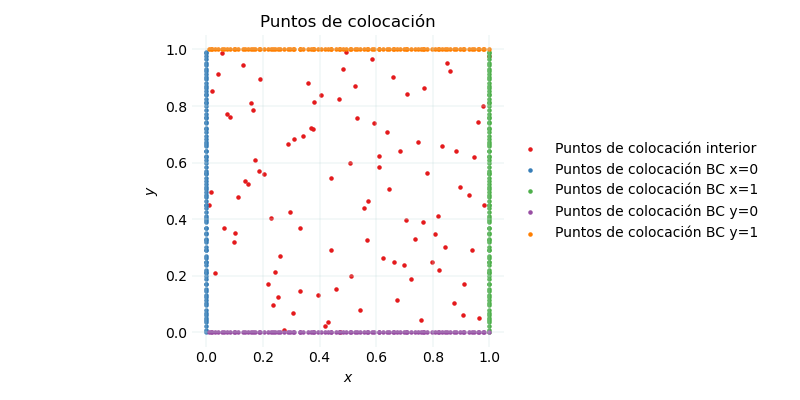

In [5]:
# Número de muestras en x y y
dom_samples = 100
x = np.linspace(0, 1, dom_samples)
y = np.linspace(0, 1, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

# Estrategia de muestreo LHS (Latin Hypercube Sampling)
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=dom_samples)

# límites inferior y superior del dominio
l_bounds = [ 0, 0]
u_bounds = [ 1, 1]
domain_xt = qmc.scale(sample, l_bounds, u_bounds)

# tensores de torch
x_ten = torch.tensor(domain_xt[:, 0], requires_grad = True).float().reshape(-1,1)
y_ten = torch.tensor(domain_xt[:, 1], requires_grad = True).float().reshape(-1,1)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(domain_xt[:, 0], domain_xt[:, 1], s=5,
           label='Puntos de colocación interior')
ax.scatter(np.zeros_like(y_ten.detach().numpy()), y_ten.detach().numpy(),
           s=5, label='Puntos de colocación BC x=0')
ax.scatter(np.ones_like(y_ten.detach().numpy()), y_ten.detach().numpy(),
           s=5, label='Puntos de colocación BC x=1')
ax.scatter(x_ten.detach().numpy(), np.zeros_like(x_ten.detach().numpy()),
           s=5, label='Puntos de colocación BC y=0')
ax.scatter(x_ten.detach().numpy(), np.ones_like(x_ten.detach().numpy()),
           s=5, label='Puntos de colocación BC y=1')   
ax.set_title('Puntos de colocación')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$') 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.axis("image")
plt.tight_layout()


### Solución analítica
Definimos la solución analítica $u(x, y) = 16\, x\, y\, (1 - x) \, (1 - y)$
para el problema de la ecuación de Poisson.



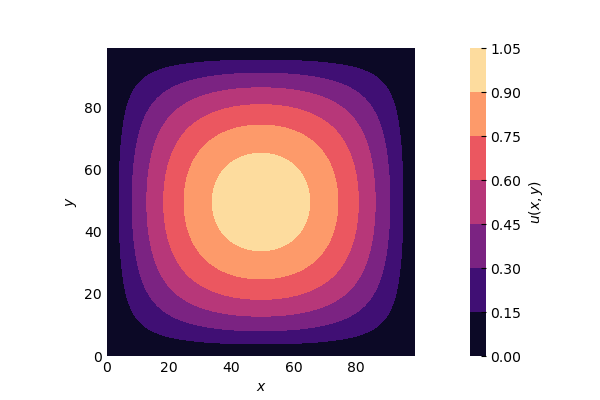

In [6]:
def u_analytic(x, y):
    return 16*(1 - x) * x * (1 - y) * y

# Mostrar la solución exacta u(x, y)
plt.figure(figsize=(6, 4))  
img = plt.contourf(u_analytic(X, Y), cmap='magma')
plt.colorbar(img, label='$u(x,y)$')   
plt.xlabel(r'$x$')   
plt.ylabel(r'$y$')
plt.axis("image")
plt.grid(False)

# Definición de red neuronal 

Ahora, utilizamos `PyTorch` y definimos la red neuronal y, para esta tarea, utilizaremos el optimizador `ADAM`.

In [7]:
# parámetros de entrenamiento
hidden_layers = [2, 10, 10, 10, 1]
learning_rate = 0.001
training_iter = 20000

# Definir una función de pérdida (Error Cuadrático Medio) para entrenar la red
MSE_func = nn.MSELoss()

# Definir una clase de red neuronal con capas y neuronas definidas por el usuario
class NeuralNetwork(nn.Module):
    
    def __init__(self, hlayers):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        for i in range(len(hlayers[:-2])):
            layers.append(nn.Linear(hlayers[i], hlayers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hlayers[-2], hlayers[-1]))
        
        self.layers = nn.Sequential(*layers)
        self.init_params
        
    def init_params(self):
        """Xavier Glorot parameter initialization of the Neural Network
        """
        def init_normal(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # Xavier
        self.apply(init_normal)

    def forward(self, x):
        return self.layers(x)
    

In [8]:
# Crear una instancia de la red neuronal
u_pinn = NeuralNetwork(hidden_layers)
nparams = sum(p.numel() for p in u_pinn.parameters() if p.requires_grad)
print(f'Número de parámetros entrenables: {nparams}')

# Definir un optimizador (Adam) para entrenar la red
optimizer = torch.optim.Adam(u_pinn.parameters(), lr=0.001, 
                       betas= (0.9,0.999), eps = 1e-8)    

Número de parámetros entrenables: 261


### Función de Pérdida Informada por la Física

In [9]:
# Definición de la función gradiente que calcula la derivada parcial de una salida con respecto a una entrada
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, 
                        grad_outputs=torch.ones_like(outputs), 
                        create_graph=True,
                        retain_graph=True)[0]

# Definición de la función de pérdida para la Red Neuronal de Ecuaciones Diferenciales Parciales (PINN)
def PINN_poisson_Loss(forward_pass, x_ten, y_ten, 
             lambda1 = 1, lambda2 = 1, lambda3 = 1, lambda4 = 1):

    # Salida de la red neuronal y primeras y segundas derivadas
    domain = torch.cat([x_ten, y_ten], dim = 1)
    u = forward_pass(domain)
    u_x = grad(u, x_ten)
    u_xx = grad(u_x, x_ten)
    u_y = grad(u, y_ten)
    u_yy = grad(u_y, y_ten)
  
    # Definición de la pérdida de la Ecuación Diferencial Parcial (PDE)
    f_pde = u_xx + u_yy +  32*((1 - y_ten)*y_ten + (1 - x_ten)*x_ten) 
    PDE_loss = lambda1 * MSE_func(f_pde, torch.zeros_like(f_pde)) 
    
    # Definición de las condiciones de contorno y sus pérdidas correspondientes
    bcy1 = torch.cat([x_ten,torch.zeros_like(y_ten)], dim = 1)
    g_bcy1 = forward_pass(bcy1)
    bcy1_loss = lambda1 * MSE_func(g_bcy1, torch.zeros_like(g_bcy1))

    bcy2 = torch.cat([x_ten, torch.ones_like(y_ten)], dim = 1)
    g_bcy2 = forward_pass(bcy2)
    bcy2_loss = lambda2 * MSE_func(g_bcy2, torch.zeros_like(g_bcy2))

    bcx1 = torch.cat([torch.zeros_like(x_ten), y_ten], dim = 1)
    g_bcx1 = forward_pass(bcx1)
    bcx1_loss = lambda3 * MSE_func(g_bcx1, torch.zeros_like(g_bcx1))
    
    bcx2 = torch.cat([torch.ones_like(x_ten), y_ten], dim = 1)
    g_bcx2 = forward_pass(bcx2)
    bcx2_loss = lambda4 * MSE_func(g_bcx2, torch.zeros_like(g_bcx2))  
    
    # La función de pérdida total es la suma de todas las pérdidas
    return PDE_loss + bcx1_loss + bcx2_loss + bcy1_loss + bcy2_loss   
    


## Entrenamiento del modelo

In [10]:
# Inicialización de una lista para almacenar los valores de pérdida
loss_values = []

# Inicio del temporizador
start_time = time.time()

# Entrenamiento de la red neuronal
for i in range(training_iter):
    
    # Limpieza de los gradientes para el próximo entrenamiento
    optimizer.zero_grad()   

    # Entrada x y predicción basada en x
    loss = PINN_poisson_Loss(u_pinn, x_ten, y_ten)
    
    # Añadir el valor actual de la pérdida a la lista
    loss_values.append(loss.item())
    
    # Imprimir cada 1000 iteraciones
    if i % 1000 == 0:  
        print(f"Iteración {i}: Pérdida {loss.item()}")
    
    # Calcular los gradientes (retropropagación)
    loss.backward() 
    # Actualizar los pesos de la red neuronal
    optimizer.step() 

# Parar el temporizador y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de entrenamiento: {elapsed_time} segundos")

Iteración 0: Pérdida 123.81940460205078
Iteración 1000: Pérdida 0.3912177085876465
Iteración 2000: Pérdida 0.1978883296251297
Iteración 3000: Pérdida 0.17823639512062073
Iteración 4000: Pérdida 0.15683487057685852
Iteración 5000: Pérdida 0.11539200693368912
Iteración 6000: Pérdida 0.07528560608625412
Iteración 7000: Pérdida 0.026973139494657516
Iteración 8000: Pérdida 0.009206104092299938
Iteración 9000: Pérdida 0.00441260589286685
Iteración 10000: Pérdida 0.0026671704836189747
Iteración 11000: Pérdida 0.0017529450124129653
Iteración 12000: Pérdida 0.0016119020292535424
Iteración 13000: Pérdida 0.000956168572884053
Iteración 14000: Pérdida 0.001327643753029406
Iteración 15000: Pérdida 0.0006727473810315132
Iteración 16000: Pérdida 0.0012858121190220118
Iteración 17000: Pérdida 0.0010178254451602697
Iteración 18000: Pérdida 0.0013089437270537019
Iteración 19000: Pérdida 0.00039903842844069004
Tiempo de entrenamiento: 75.30693244934082 segundos


## Predicción

In [11]:
# Convertir los datos X e Y a tensores de PyTorch y cambiar su forma
X_ten = torch.tensor(X).float().reshape(-1, 1)
Y_ten = torch.tensor(Y).float().reshape(-1, 1)

# Concatenar los tensores X e Y en un solo tensor
domain_ten = torch.cat([X_ten,Y_ten], dim = 1)

# Generar predicciones usando la red neuronal y cambiar la forma para que coincida con la cuadrícula
U_pred = u_pinn(domain_ten).detach().numpy().reshape(X.shape)

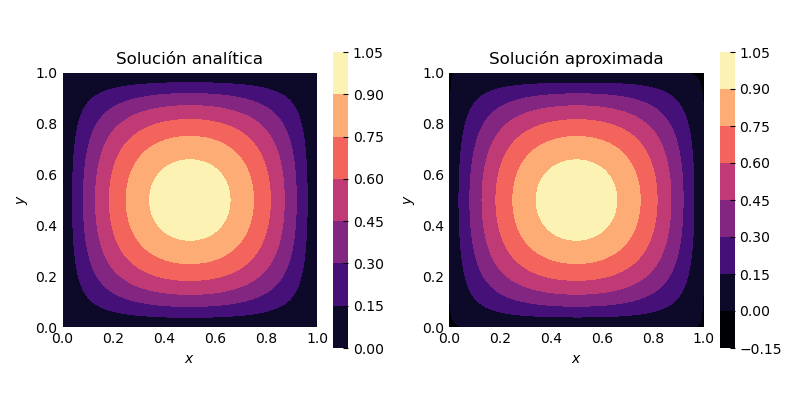

In [12]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, u_analytic(X, Y), cmap='magma',
            vmin=0, vmax=1)
plt.colorbar(shrink=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Solución analítica")
plt.axis("image")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.contourf(X, Y, U_pred, cmap='magma',
            vmin=0, vmax=1)
plt.colorbar(shrink=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Solución aproximada")
plt.axis("image")
plt.grid(False)

plt.tight_layout()

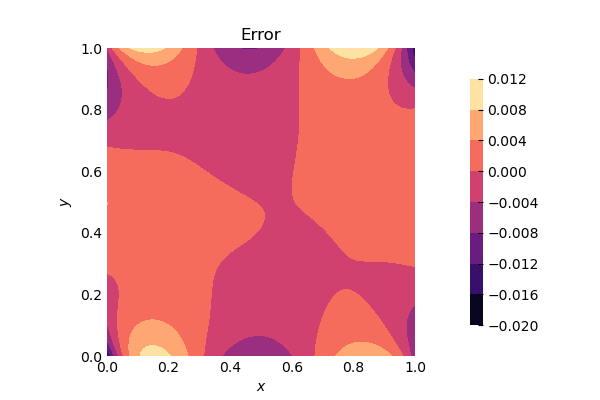

In [13]:
plt.figure()
plt.contourf(X, Y, U_pred - u_analytic(X, Y), cmap='magma')
plt.colorbar(shrink=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Error")
plt.axis("image")
plt.grid(False)